In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math

In [3]:
#veri setini yüklüyoruz ve sadece kapanış fiyatını alıyoruz

df = web.DataReader("AAPL", data_source="yahoo", start="2012-01-01", end="2021-11-13")
data = df.filter(["Close"])


In [4]:
data

,Close
Date,
2012-01-03,14.686786
2012-01-04,14.765714
2012-01-05,14.929643
2012-01-06,15.085714
2012-01-09,15.061786
...,...
2021-11-08,150.440002
2021-11-09,150.809998
2021-11-10,147.919998


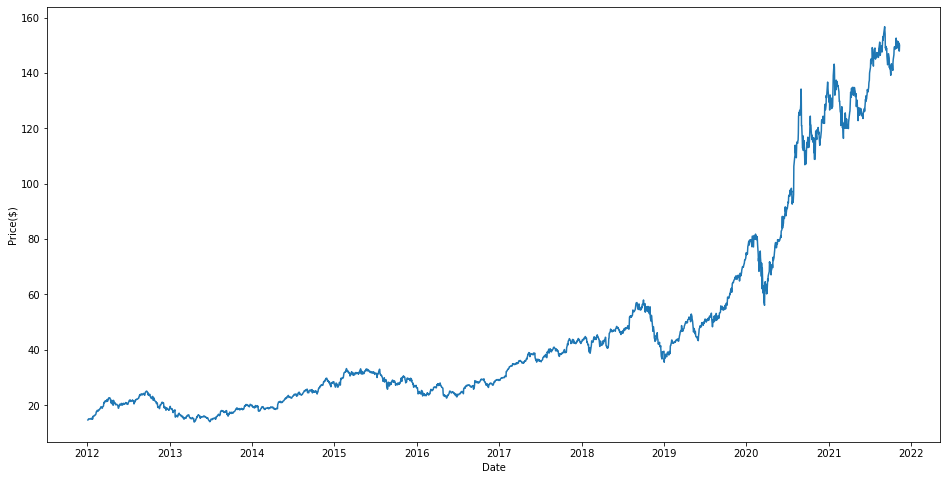

In [5]:
#veri setinin grafik üzerindeki hali

plt.figure(figsize=(16,8))
plt.ylabel('Price($)')
plt.xlabel('Date')
plt.plot(data)
plt.show()

In [6]:
#veri setini train ve test olarak ikiye ayırdık (%80 train ve %20 test)

dataset_train = np.array(data[:int(df.shape[0]*0.8)])
dataset_test = np.array(data[int(df.shape[0]*0.8):])

In [7]:
#veriyi daha iyi görebilmek için 0,1 arasındaki değerlere sıkıştırdık

scaler = MinMaxScaler()
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.fit_transform(dataset_test)

In [8]:
#çalışma verisini x_train ve y_train olarak ikiye bölüyoruz. x_train dizisine son 60 değeri, y_train dizisine ise tahmin 
#etmesini istediğimiz 61.değeri atıyoruz

x_train = []
y_train = []

for i in range(60, len(dataset_train)):
    x_train.append(dataset_train[i-60:i, 0])
    y_train.append(dataset_train[i, 0])

In [9]:
#x_train ve y_traini dizilerini lstm modelde kullanabilmek için "array" dönüştürdük ve 3 boyutlu hale getirdik

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


(1927, 60, 1)

In [10]:
#tahmin için lstm modeli oluşturuyoruz

model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(20))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 20)            1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [11]:
#modeli eğitiyoruz

model.fit(x_train, y_train, epochs=3, batch_size=32)


Epoch 1/3
61/61 [==============================] - 4s 29ms/step - loss: 0.0130
Epoch 2/3
61/61 [==============================] - 2s 28ms/step - loss: 7.8781e-04
Epoch 3/3
61/61 [==============================] - 2s 29ms/step - loss: 7.1724e-04


In [12]:
#test verisini oluşturmuştuk, x_test dizisini oluşturup değerleri atadık

#test = np.array(data[int(df.shape[0]*0.8)-60:])

x_test = []
for i in range(60, len(dataset_test)):
    x_test.append(dataset_test[i-60:i, 0])

In [13]:
#test verisini oluşturmuştuk, x_test dizisini oluşturup değerleri atadık, ilk değeri tahmin edebilmemiz için önceki 60 değer
#gerekliydi o yüzden 60 çıkarttık

#test = np.array(data[int(df.shape[0]*0.8)-60:])

#x_test = []
#for i in range(60, len(test)):
#    x_test.append(test[i-60:i, 0])
    

In [14]:
#y_test verimiz x_testin tahmin etmesini istediğimiz değerler. y_test verimizi oluşturuyoruz
#datadaki verileri değerlere dönüştürdük ve o değerleri y_test dizisine atadık

dataset= data.values

y_test = dataset[len(dataset_train)+60: , :]


In [15]:
#lstm modelde kullanabilmek için "array" dönüştürdük ve 3 boyutlu hale getirdik

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [16]:
#oluşturduğumuz lstm modelin tahmin yapmasını sağlıyoruz ve bulduğu değeri inverse_transform kullanarak normal değere
#dönüştüyoruz

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [17]:
#hatayı ölçüyoruz
MSE = np.square(np.subtract(y_test,predictions)).mean()
RMSE = math.sqrt(MSE)
print(RMSE)

5.334180534012684


In [18]:
#hatayı ölçüyoruz
rmse = np.sqrt(np.mean(predictions - y_test)**2 )
rmse

0.7991969547228082

In [19]:
training_data_len = len(dataset_train)+60
train = data[:training_data_len]
actual_price = data[training_data_len:]
actual_price["Predictions"] = predictions

<ipython-input-19-181723ccdec4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_price["Predictions"] = predictions


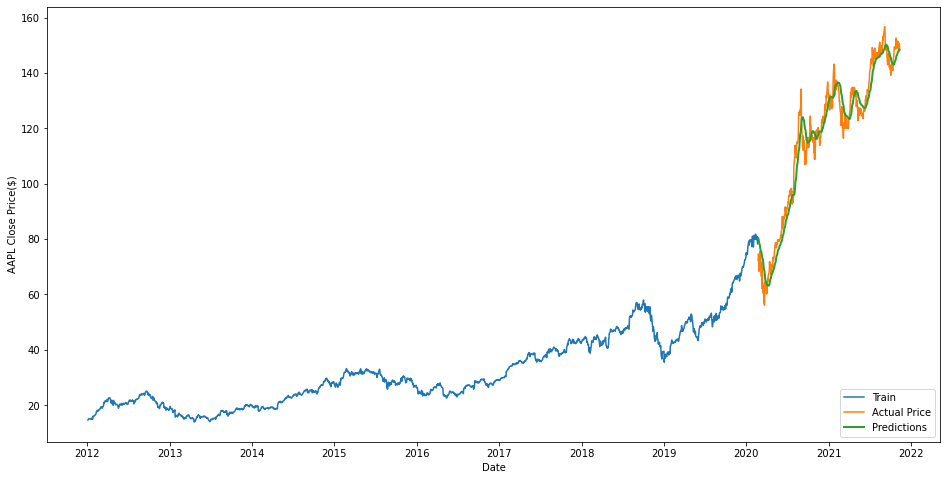

In [20]:
plt.figure(figsize=(16,8))
plt.ylabel('AAPL Close Price($)')
plt.xlabel('Date')
plt.plot(train["Close"])
plt.plot(actual_price[["Close"]])
plt.plot(actual_price[["Predictions"]], linewidth=2)
plt.legend(["Train", "Actual Price", "Predictions"],loc="lower right")
plt.show()



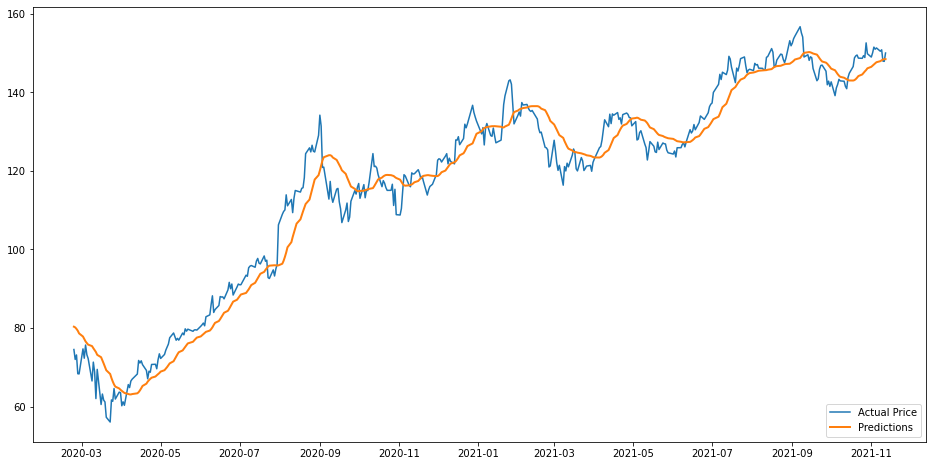

In [21]:
plt.figure(figsize=(16,8))
plt.plot(actual_price[["Close"]])
plt.plot(actual_price[["Predictions"]], linewidth=2)
plt.legend(["Actual Price", "Predictions"],loc="lower right")
plt.show()

In [22]:
actual_price

,Close,Predictions
Date,,
2020-02-24,74.544998,80.351799
2020-02-25,72.019997,80.170113
2020-02-26,73.162498,79.787827
2020-02-27,68.379997,79.314781
2020-02-28,68.339996,78.642021
...,...,...
2021-11-08,150.440002,147.921600
2021-11-09,150.809998,148.147278
2021-11-10,147.919998,148.348938


In [23]:
ticker = web.DataReader("AAPL", data_source="yahoo", start="2012-01-01", end="2022-01-03")
new_df = ticker.filter(["Close"])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

X_test = []

X_test.append(last_60_days_scaled)

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)

pred_price = scaler.inverse_transform(pred_price)

print(pred_price)



[[168.25386]]


In [24]:
apple2 = web.DataReader("AAPL", data_source="yahoo", start="2022-01-04", end="2022-01-04")
print(apple2["Close"])

Date
2022-01-04    179.699997
Name: Close, dtype: float64
